In [1]:
import sys
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from sklearn import metrics
import pandas as pd
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet,mobilenet_v2,inception_v3,efficientnet

In [ ]:
layer = tf.keras.layers.Conv2D()

In [2]:
def Evaluate(model: keras.engine.sequential.Sequential):
    print("Evalutions... ", "\n", 
      "Train -> ", model.evaluate(X_train, y_train), "\n",
      "Test -> ", model.evaluate(X_test, y_test), "\n",
      "Validation -> ", model.evaluate(X_val, y_val))

def SizeOfNet(model: bytes):
    print("Size -->", len(model), "bytes")

In [3]:
dataset=pd.read_csv(r'C:\Users\nikita\X-RAY\sample_labels.csv')
dataset

# number of findings

dataset['Finding Labels'].value_counts()

# define categories and separate them ->

diagnosis=np.array(dataset['Finding Labels'])
deseases=[]

for i in range(len(diagnosis)):
    splitter=diagnosis[i].split("|")
    if len(splitter)==1:
            deseases.append(splitter)
    else:
        lab=[]
        for j in range(len(splitter)):
            lab.append(splitter[j])
        deseases.append(lab)
print('Numer of findings =',len(deseases))

Numer of findings = 5606


100%|██████████████████████████████████████████████████████████████████████████████| 5606/5606 [01:01<00:00, 91.44it/s]


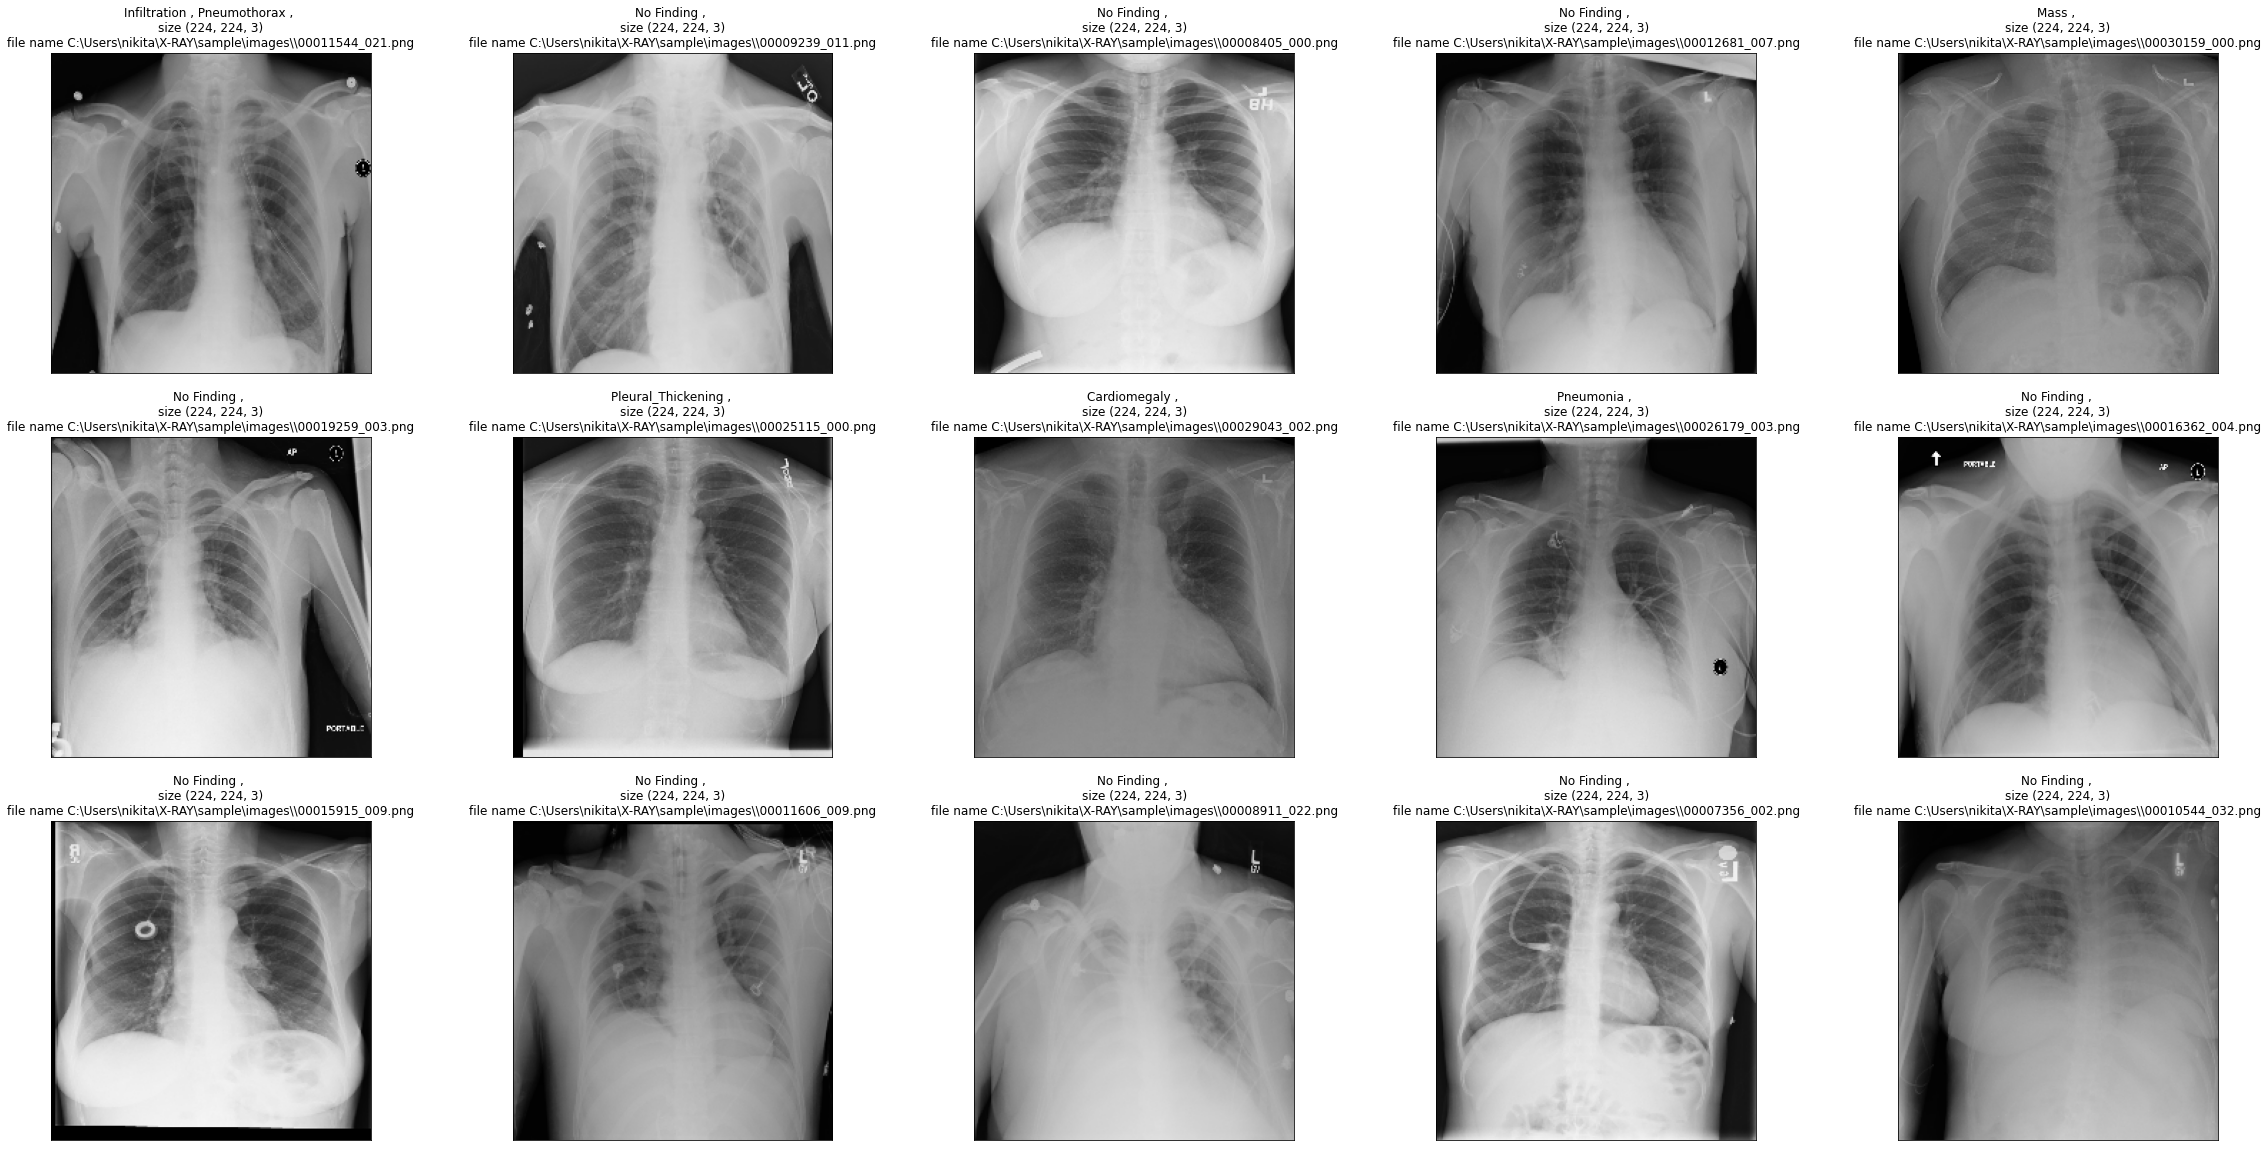

In [4]:
img_size=224
source=r'C:\Users\nikita\X-RAY\sample\images\\'
labels=[]
scans=[]
file = []

for i in tqdm(range(len(dataset["Image Index"]))):
    img=cv2.imread(source+dataset["Image Index"][i])
    if len(img.shape)>2: # to save images as (heigth , width, 3) rather than (hieght , width ,4)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img[:,:,:4])
    else :
        img=np.dstack([img] * 3)
        resize_img=cv2.resize(img,(img_size,img_size)) 
        scans.append(resize_img)
    file.append(source+dataset["Image Index"][i])

def img_show(data,deseases,number_of_image):
    order=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(40,20))
    j = int(number_of_image/5)
    for _,i in enumerate(order):
        plt.subplot(j,5,_+1)
        plt.imshow(data[i] , cmap="gray")
        label=""
        if i < len(deseases):
            for x in deseases[i]:
                label+=x+" , "

            
        plt.title(label+"\n"+f"size {data[i].shape}"+ "\n"+
                 f"file name {file[i]}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()


img_show(scans, deseases, 15)

In [5]:
classes={
0:"Hernia",
1:"Pneumonia",
2:"Fibrosis",
3:"Edema",
4:"Emphysema",
5:"Cardiomegaly",
6:"Pleural_Thickening",
7:"Consolidation",
8:"Pneumothorax",
9:"Mass",
10:"Nodule",
11:"Atelectasis",
12:"Effusion",
13:"Infiltration",
14:"No Finding",
}

In [6]:
deseases

[['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Cardiomegaly', 'Emphysema'],
 ['No Finding'],
 ['Atelectasis'],
 ['Cardiomegaly', 'Edema', 'Effusion'],
 ['Consolidation', 'Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['No Finding'],
 ['Consolidation', 'Effusion', 'Infiltration', 'Nodule'],
 ['Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['Effusion'],
 ['Effusion'],
 ['No Finding'],
 ['Mass', 'Pneumothorax'],
 ['Cardiomegaly', 'Consolidation'],
 ['Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Pneumothorax'],
 ['No Finding'],
 ['Effusion'],
 ['Consolidation', 'Pleural_Thickening'],
 ['Infiltration', 'Nodule'],
 ['No Finding'],
 ['Atelectasis'],
 ['Atelectasis'],
 ['Fibrosis'],
 ['Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Fibrosis'],
 ['No Finding'],
 ['Consolidation'],
 ['Emphysema'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltra

In [7]:
def getter_class(code):
    return classes[code]

def getter_code(labels):
    for key,value in classes.items():
        if value ==labels:
            return key

In [8]:
scans = np.array(scans)

for i in tqdm(range(len(deseases))):
    deseases[i]=[getter_code(x) for x in deseases[i]]

deseases[:10]

100%|██████████████████████████████████████████████████████████████████████████| 5606/5606 [00:00<00:00, 702664.68it/s]


[[4, 13, 6, 8], [5, 4], [14], [11], [5, 3, 12], [7, 9], [14], [14], [12], [14]]

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlp=MultiLabelBinarizer()
Labels=mlp.fit_transform(deseases)
Labels = np.array(Labels)
scans.shape

(5606, 224, 224, 3)

In [10]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score

#split to train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(scans, Labels, test_size = 0.2 )

#split to valid and test
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size = 0.7)

In [11]:
print("input 1 for efficient_net, 2 for mobile_net ", end='')

choice = int(input())

if (choice == 1):
    my_model = keras.Sequential()
    model_general=tf.keras.applications.MobileNet(input_shape=(224, 224, 3))
    
    for layer in model_general.layers[:-1]:
        my_model.add(layer)
    my_model.add(keras.layers.Dense(15, activation=keras.activations.softmax))
elif (choice == 2):
    model_general=tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))
    
    last_l = model_general.output
    last_l = tf.keras.layers.GlobalAveragePooling2D()(last_l)
    last_l = tf.keras.layers.Dense(1024, activation='relu')(last_l)
    predictions_resnet = tf.keras.layers.Dense(15, activation="softmax")(last_l)
    my_model = tf.keras.Model(model_general.input, predictions_resnet)
else:
    print("!wrong input")
    
for l in my_model.layers:
    l.trainable = False

input 1 for efficient_net, 2 for mobile_net 2


In [12]:
model_general.summary(), my_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
          

 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)       

                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

(None, None)

In [13]:
# define callbacks

callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1),
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.h5",save_best_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=1, min_delta = 0.001,
                                      min_lr=0.000001,
                                      mode = 'min',verbose=1)]

In [ ]:
# compile & fit

my_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.binary_crossentropy,metrics=["accuracy"] )

my_model.fit(X_train,y_train,epochs=10, 
          batch_size=32,validation_data=(X_val, y_val),verbose=1, callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.0829
Epoch 1: val_loss improved from inf to 0.93891, saving model to NIH_model_1.h5
141/141 [==============================] - 30s 85ms/step - loss: 0.9557 - accuracy: 0.0829 - val_loss: 0.9389 - val_accuracy: 0.0693 - lr: 1.0000e-04
Epoch 2/10
140/141 [============================>.] - ETA: 0s - loss: 0.9556 - accuracy: 0.0830
Epoch 2: val_loss did not improve from 0.93891

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
141/141 [==============================] - 10s 70ms/step - loss: 0.9557 - accuracy: 0.0829 - val_loss: 0.9389 - val_accuracy: 0.0693 - lr: 1.0000e-04
Epoch 3/10
140/141 [============================>.] - ETA: 0s - loss: 0.9557 - accuracy: 0.0828
Epoch 3: val_loss did not improve from 0.93891

Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.
141/141 [==============================] - 10s 68ms/step - loss: 0.9557 - accuracy: 0.0829 - val_loss